# Klasifikasi Penyakit Buah Mangga

## Import Dataset dan Library


In [6]:
!gdown 1678-hyJPogqsL88c2ETiDNCCGEgsy1JU

Downloading...
From (original): https://drive.google.com/uc?id=1678-hyJPogqsL88c2ETiDNCCGEgsy1JU
From (redirected): https://drive.google.com/uc?id=1678-hyJPogqsL88c2ETiDNCCGEgsy1JU&confirm=t&uuid=6942463e-b523-4da1-81cf-9d8afa9af123
To: /content/MangoFruitDDS.zip
100% 64.4M/64.4M [00:01<00:00, 56.4MB/s]


In [7]:
!rm -rf /content/MangoFruitDDS
!unzip -q MangoFruitDDS.zip -d /content/

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix

## Preprocessing

### Data Preparation

In [9]:
image_size = 224
batch_size = 32
channels = 3
epochs = 200
learning_rate = 0.01

In [10]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/MangoFruitDDS',
    shuffle=True,
    image_size=(image_size, image_size),
    batch_size=batch_size
)
class_names = dataset.class_names
print(class_names)

Found 1700 files belonging to 5 classes.
['Alternaria', 'Anthracnose', 'Black Mould Rot', 'Healthy', 'Stem end Rot']


In [11]:
total_samples = 0
class_counts = {}

for images, labels in dataset:
  total_samples += images.shape[0]
  for label in labels.numpy():
    class_name = class_names[label]
    class_counts[class_name] = class_counts.get(class_name, 0) + 1

print("Total data:", total_samples)
print("\nData per class:")
for class_name, count in class_counts.items():
  print(f"Total citra kelas {class_name}: {count}")

Total data: 1700

Data per class:
Total citra kelas Black Mould Rot: 368
Total citra kelas Stem end Rot: 323
Total citra kelas Alternaria: 335
Total citra kelas Healthy: 413
Total citra kelas Anthracnose: 261


### Data Visualization

Visualisasi Citra: Alternaria


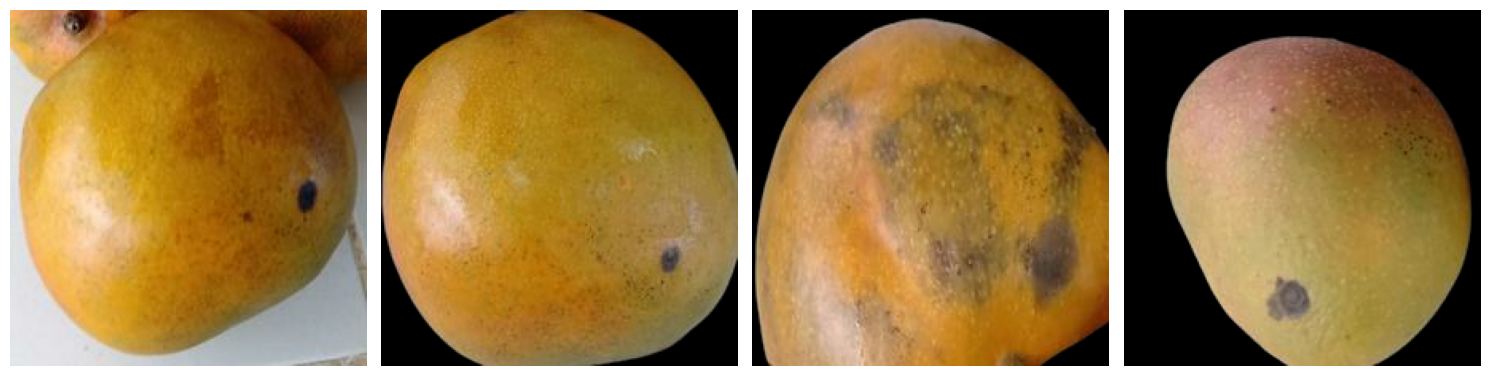

Visualisasi Citra: Anthracnose


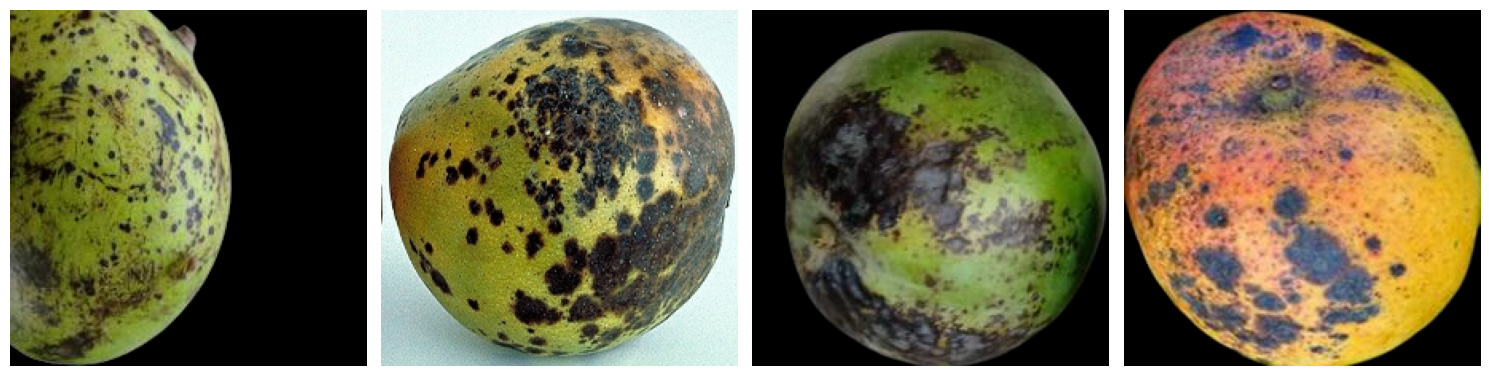

Visualisasi Citra: Black Mould Rot


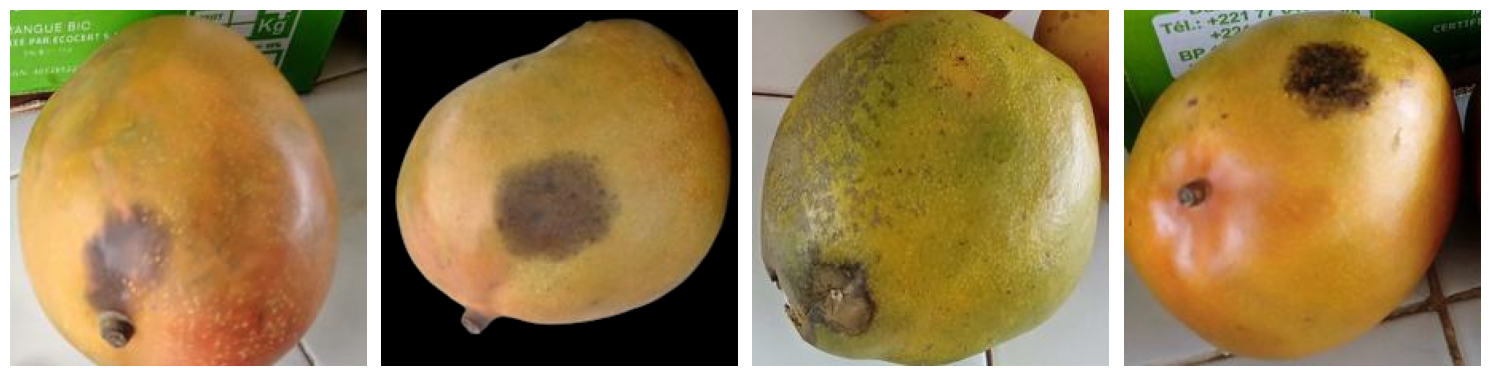

Visualisasi Citra: Healthy


Visualisasi Citra: Stem end Rot


In [12]:
def visualize_images(dataset, class_names):
  for class_name in class_names:
    print(f"Visualisasi Citra: {class_name}")
    count = 0
    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    for images, labels in dataset:
      for i in range(images.shape[0]):
          if class_names[labels[i]] == class_name and count < 4:
              axes.ravel()[count].imshow(images[i].numpy().astype("uint8"))
              axes.ravel()[count].axis("off")
              count += 1
          if count == 4:
              break
      if count == 4:
          break
    plt.tight_layout()
    plt.show()

visualize_images(dataset, class_names)

### Data Splitting

In [13]:
# Membagi dataset menjadi Train, Validation, Test

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_dataset = ds.take(train_size)
  val_dataset = ds.skip(train_size).take(val_size)
  test_dataset = ds.skip(train_size).skip(val_size)

  return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(dataset)

In [14]:
print("Jumlah Batch: ", len(dataset))
print("Jumlah Batch untuk Train: ", len(train_dataset))
print("Jumlah Batch untuk Validation: ", len(val_dataset))
print("Jumlah Batch untuk Test: ", len(test_dataset))

Jumlah Batch:  54
Jumlah Batch untuk Train:  43
Jumlah Batch untuk Validation:  5
Jumlah Batch untuk Test:  6


### Encoding

In [15]:
for features, labels in dataset.take(1):
    print("Features shape:", features.shape)
    print("Labels shape:", labels.shape)

Features shape: (32, 224, 224, 3)
Labels shape: (32,)


In [16]:
num_classes = 5

def one_hot_encode(features, labels):
    labels = tf.one_hot(labels, depth=num_classes)
    return features, labels

train_dataset = train_dataset.map(one_hot_encode)
val_dataset = val_dataset.map(one_hot_encode)
test_dataset = test_dataset.map(one_hot_encode)


### Data Augmentation

In [17]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(image_size, image_size),
    layers.Rescaling(1./255)
])

In [19]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
], name="data_augmentation")


In [20]:
train_dataset = train_dataset.map(lambda x, y: (resize_and_rescale(x), y))
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
val_dataset = val_dataset.map(lambda x, y: (resize_and_rescale(x), y))
test_dataset = test_dataset.map(lambda x, y: (resize_and_rescale(x), y))

## Training

### CNN Model

In [21]:
model = models.Sequential([
    layers.Input(shape=(image_size, image_size, channels)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.AveragePooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.AveragePooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.AveragePooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.AveragePooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.AveragePooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(5, activation='softmax'),
])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 54, 54, 64)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_2                  │ (None, 26, 26, 64)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_3                  │ (None, 12, 12, 64)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_4                  │ (None, 5, 5, 64)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 232,965 (910.02 KB)

 Trainable params: 232,965 (910.02 KB)

 Non-trainable params: 0 (0.00 B)

### Callbacks for Early Stopping

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

### Training Process

In [23]:
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_dataset,
    batch_size=batch_size,
    validation_data=val_dataset,
    verbose=1,
    epochs=epochs,
    callbacks= early_stopping
)

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 33s 485ms/step - accuracy: 0.2052 - loss: 1.6985 - val_accuracy: 0.2313 - val_loss: 1.5673
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 271ms/step - accuracy: 0.2702 - loss: 1.5594 - val_accuracy: 0.2750 - val_loss: 1.5603
Epoch 3/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 274ms/step - accuracy: 0.2773 - loss: 1.5411 - val_accuracy: 0.3187 - val_loss: 1.5362
Epoch 4/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 260ms/step - accuracy: 0.2908 - loss: 1.4952 - val_accuracy: 0.3063 - val_loss: 1.5314
Epoch 5/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 283ms/step - accuracy: 0.2661 - loss: 1.5111 - val_accuracy: 0.2313 - val_loss: 1.5647
Epoch 6/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 272ms/step - accuracy: 0.3216 - loss: 1.4992 - val_accuracy: 0.3438 - val_loss: 1.5405
Epoch 7/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 274ms/step - accuracy: 0.3161 - loss: 1.5024 - val_accuracy: 0.3125 - val_loss: 1.5073
Epoch 8/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 267ms/step - accuracy: 0.2998 - loss: 1.4753 - 

## Evaluation

### Accuracy and Loss

In [25]:
evaluation = model.evaluate(test_dataset)
print("Accuracy:", evaluation[1])
print("Loss:", evaluation[0])

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.3513 - loss: 1.4747
Accuracy: 0.328125
Loss: 1.4671732187271118


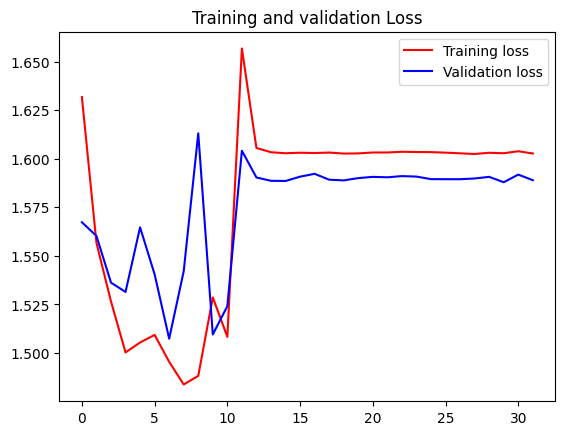

<Figure size 640x480 with 0 Axes>

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()

plt.show()

### Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


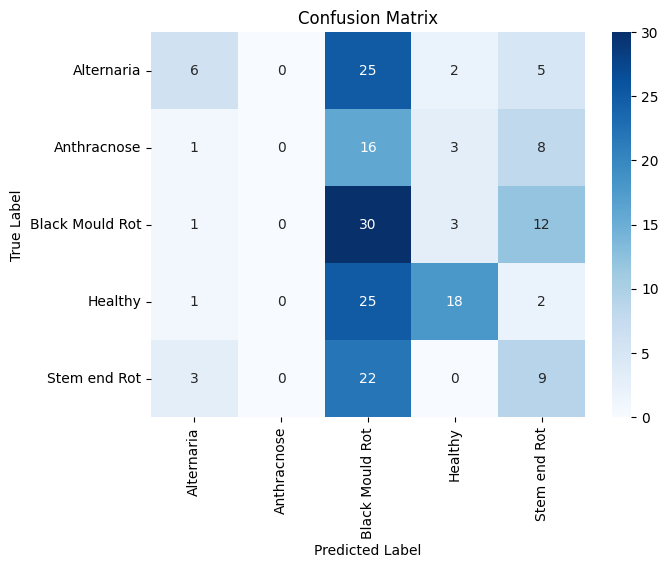

In [27]:
y_true = []
y_pred = []

for images, labels in test_dataset:
  predictions = model.predict(images)
  predicted_labels = np.argmax(predictions, axis = 1)
  true_labels = np.argmax(labels.numpy(), axis = 1)
  y_true.extend(true_labels)
  y_pred.extend(predicted_labels)

confusion_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize= (7,5))
sns.heatmap(confusion_matrix, annot=True, fmt="d",
cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### Visualize Prediciton

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


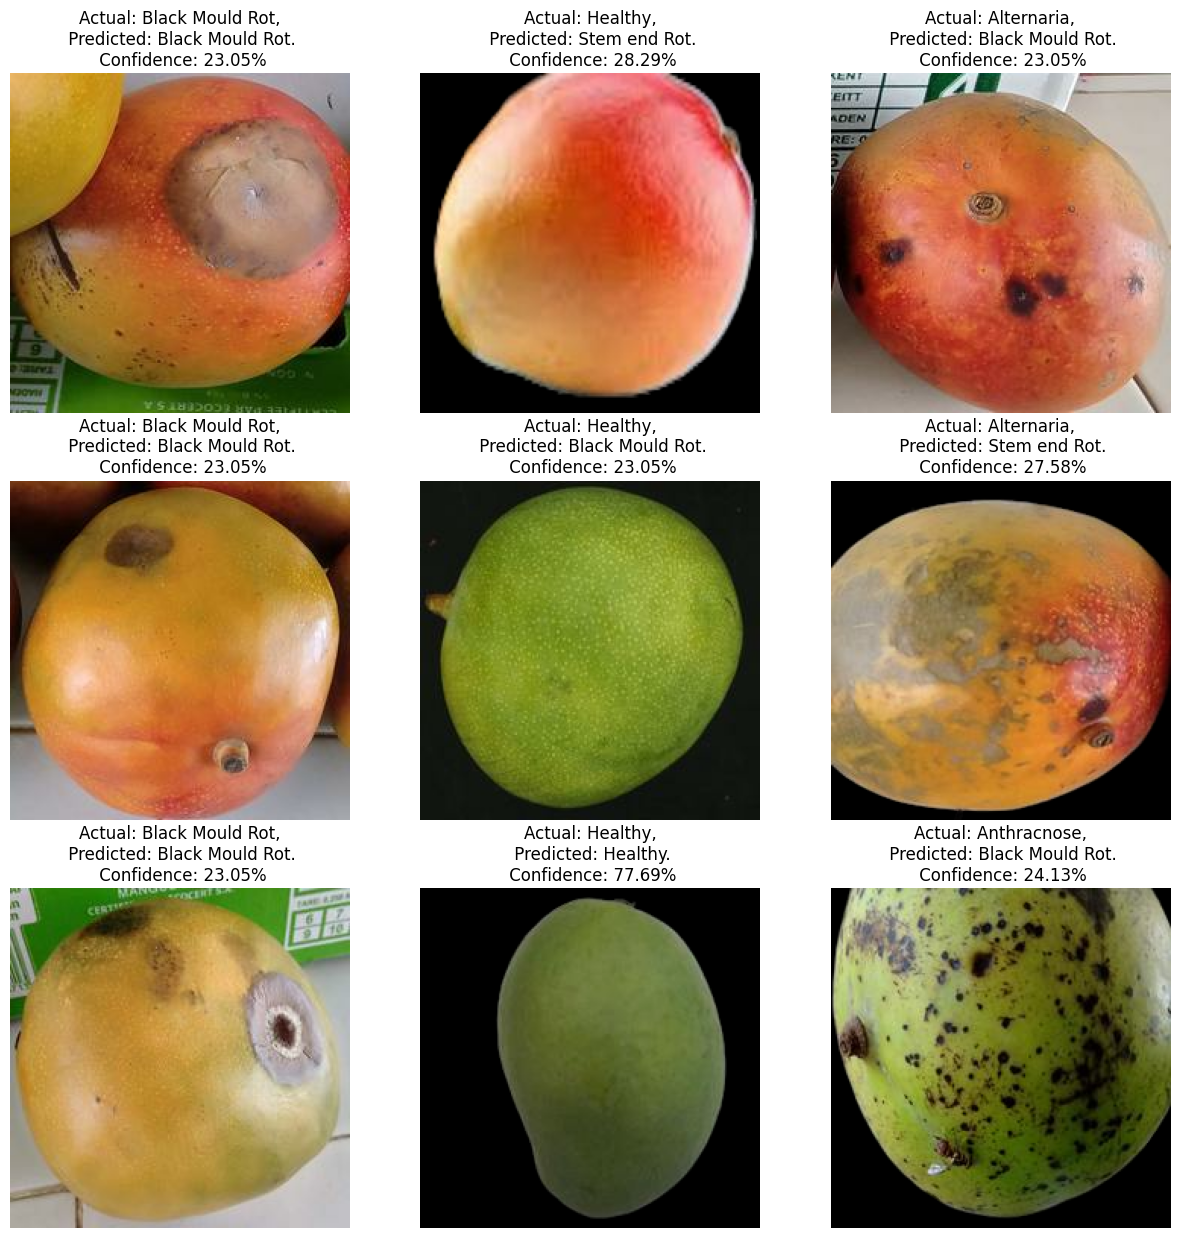

In [28]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(tf.cast(images[i] * 255.0, tf.uint8).numpy())


        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[np.argmax(labels[i].numpy())]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

## Export Model

In [29]:
model.save('MangoFruitDDS.h5')

In [30]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Saved artifact at '/tmp/tmpcv9dinis'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_6')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  138029717980752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138029717994384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138029717979792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138029717995152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138029717994576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138029717979408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138029716832528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138029716833680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138029716833296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138029716834256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138029716834

In [31]:
tflite_model_file = pathlib.Path('MangoFruitDDS.tflite')
tflite_model_file.write_bytes(tflite_model)

937144